In [56]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from data_loader import load_images_and_labels

# Preprocessing and Feature Engineering Data

In [57]:
directory = "caltech-101/101_ObjectCategories"
img_height = 128
img_width = 128

images, labels, class_names = load_images_and_labels(directory, img_height, img_width)

In [58]:
images = images / 255.0 # normalize image color values from 0-255 to 0-1
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=123)
 
print("Class Names:", class_names)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Class Names: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ba

In [59]:
images[0]

array([[[0.34901962, 0.3372549 , 0.31764707],
        [0.37254903, 0.36078432, 0.34117648],
        [0.3529412 , 0.34117648, 0.32156864],
        ...,
        [0.5058824 , 0.5764706 , 0.49019608],
        [0.49803922, 0.5529412 , 0.4627451 ],
        [0.47843137, 0.5254902 , 0.44705883]],

       [[0.3372549 , 0.3254902 , 0.30588236],
        [0.34509805, 0.33333334, 0.3137255 ],
        [0.34901962, 0.3372549 , 0.31764707],
        ...,
        [0.4862745 , 0.5529412 , 0.47843137],
        [0.4745098 , 0.53333336, 0.4509804 ],
        [0.46666667, 0.5176471 , 0.44705883]],

       [[0.3372549 , 0.3254902 , 0.30588236],
        [0.34509805, 0.33333334, 0.3137255 ],
        [0.36078432, 0.34901962, 0.32941177],
        ...,
        [0.44313726, 0.50980395, 0.44705883],
        [0.43529412, 0.49411765, 0.41960785],
        [0.42745098, 0.47843137, 0.4117647 ]],

       ...,

       [[0.14117648, 0.13333334, 0.07450981],
        [0.1254902 , 0.11764706, 0.05882353],
        [0.12941177, 0

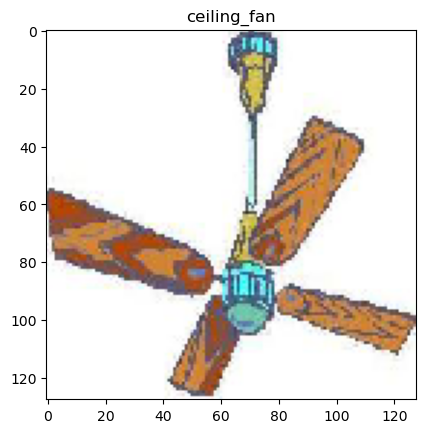

In [60]:
# show a random image
index = random.randint(0, len(x_train))
plt.imshow(x_train[index])
plt.title(class_names[y_train[index]])
plt.show()

# CNN Model

In [61]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 63, 63, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_8 (Flatten)         (None, 127008)            0         
                                                                 
 dense_17 (Dense)            (None, 512)               65028608  
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [62]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [63]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
174/174 [==============================] - 48s 271ms/step - loss: 9.6427 - accuracy: 0.2127 - val_loss: 4.5364 - val_accuracy: 0.1159
Epoch 2/10
174/174 [==============================] - 41s 232ms/step - loss: 3.4381 - accuracy: 0.2923 - val_loss: 4.0703 - val_accuracy: 0.2520
Epoch 3/10
174/174 [==============================] - 42s 244ms/step - loss: 3.1280 - accuracy: 0.3419 - val_loss: 3.3443 - val_accuracy: 0.3427
Epoch 4/10
174/174 [==============================] - 46s 263ms/step - loss: 2.7389 - accuracy: 0.3961 - val_loss: 3.0016 - val_accuracy: 0.3808
Epoch 5/10
174/174 [==============================] - 46s 264ms/step - loss: 2.4765 - accuracy: 0.4449 - val_loss: 2.9833 - val_accuracy: 0.4010
Epoch 6/10
174/174 [==============================] - 42s 242ms/step - loss: 2.1601 - accuracy: 0.5013 - val_loss: 2.8308 - val_accuracy: 0.4176
Epoch 7/10
174/174 [==============================] - 42s 239ms/step - loss: 1.9131 - accuracy: 0.5430 - val_loss: 2.7631 - val_ac

In [55]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

55/55 [==============================] - 3s 58ms/step - loss: 3.8266 - accuracy: 0.4510
Test accuracy: 0.45103687047958374


In [ ]:
# train another 10 epochs
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

55/55 [==============================] - 3s 58ms/step - loss: 3.8266 - accuracy: 0.4510
Test accuracy: 0.45103687047958374


In [54]:
model.save("cnn_model_best.h5")

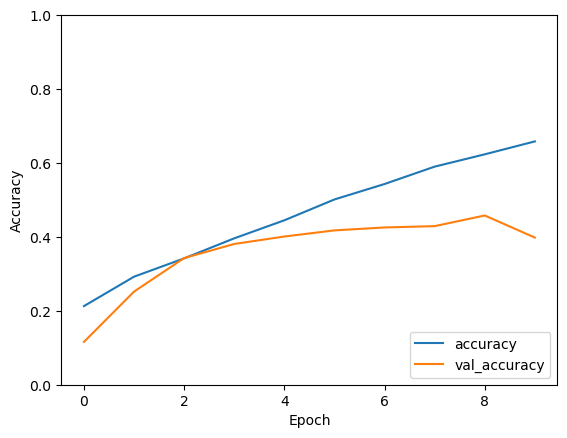

In [67]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Use transfer learning to improve results

In [69]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

94765736/94765736 [==============================] - 3s 0us/step


In [72]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
174/174 [==============================] - 85s 492ms/step - loss: 3.1931 - accuracy: 0.3274 - val_loss: 3.2798 - val_accuracy: 0.3067
Epoch 2/10
174/174 [==============================] - 78s 445ms/step - loss: 3.1458 - accuracy: 0.3312 - val_loss: 3.2411 - val_accuracy: 0.3146
Epoch 3/10
174/174 [==============================] - 78s 451ms/step - loss: 3.1063 - accuracy: 0.3401 - val_loss: 3.2213 - val_accuracy: 0.3348
Epoch 4/10
174/174 [==============================] - 90s 519ms/step - loss: 3.0658 - accuracy: 0.3462 - val_loss: 3.1847 - val_accuracy: 0.3362
Epoch 5/10
174/174 [==============================] - 86s 496ms/step - loss: 3.0276 - accuracy: 0.3518 - val_loss: 3.1578 - val_accuracy: 0.3456
Epoch 6/10
174/174 [==============================] - 84s 482ms/step - loss: 2.9904 - accuracy: 0.3568 - val_loss: 3.1335 - val_accuracy: 0.3513
Epoch 7/10
174/174 [==============================] - 92s 528ms/step - loss: 2.9572 - accuracy: 0.3628 - val_loss: 3.0994 - val_ac

In [73]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

55/55 [==============================] - 22s 405ms/step - loss: 3.0340 - accuracy: 0.3497
Test accuracy: 0.3496543765068054


In [74]:
model.save("resnet_model_best_20_epochs.h5")

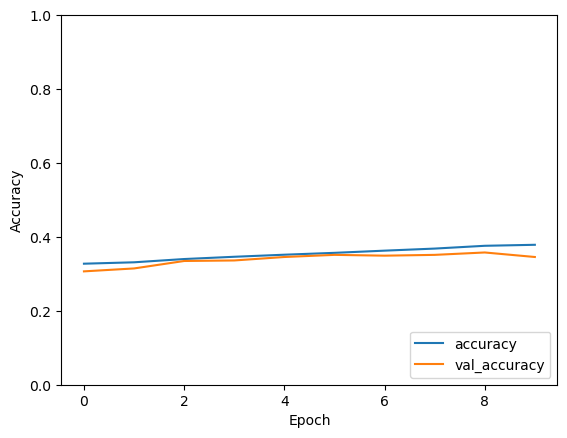

In [75]:
# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 